<a href="https://colab.research.google.com/github/racheltu2020/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [1]:
# TODO - your code!
### YOUR CODE STARTS HERE
import pandas as pd
import numpy as np

# Grab the file from UCI:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

#from google.colab import files    #using promp method to import file 
#uploaded = files.upload()


--2020-05-13 02:50:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.06s   

2020-05-13 02:50:13 (286 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



In [0]:
votes_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data"
column_headers = ['party','handicapped-infants','water-project',
                  'budget','physician-fee-freeze', 'el-salvador-aid',
                  'religious-groups','anti-satellite-ban',
                  'aid-to-contras','mx-missile','immigration',
                  'synfuels', 'education', 'right-to-sue','crime','duty-free',
                  'south-africa']
df = pd.read_csv(votes_url, names= column_headers)
df.head()

In [0]:
df_clean = df.replace({'y':1, 'n':0, '?':np.NaN})
df_clean.info()

# seperate df_clean to df_rep & df_dem based on party difference

rep = df_clean[df['party'] == 'republican']
dem = df_clean[df['party'] == 'democrat']

In [47]:
# pick water-project, dropna

x = 'water-project'
wj_rep = []
wj_dem = []
wj_rep = rep[x].dropna()
wj_dem = dem[x].dropna()
len(wj_dem)

239

239

In [0]:
# take an array, calculate its mean, std. size, std_error, t,
# calculat its confidence intervals, upper bound, lower bound
# return lower bound, mean, upper bound

def confidence_interval(data, confidence=0.95):
  x_bar = np.mean(data)
  n = len(data)
  s = np.std(data, ddof=1)
  std_err = s / np.sqrt(n)
  t = stats.t.ppf((1 + confidence) / 2.0, n - 1)
  margin_of_error = t*std_err
  lower_bound = x_bar - margin_of_error
  upper_bound = x_bar + margin_of_error
  return (lower_bound, x_bar, upper_bound)

In [0]:
# calling confidence_interval on water-project issues
# for different party (republic and democrat)
# as sample size difference

from scipy.stats import chisquare  # One-way chi square test
from scipy.stats import t, ttest_1samp
from scipy import stats 

wj_rep_length = len(wj_rep)
wj_dem_length = len(wj_dem)

lower_r, mean_r, upper_r = confidence_interval(wj_rep)
lower_d, mean_d, upper_d = confidence_interval(wj_dem) 

In [0]:
# margin of error 
moe_r = upper_r - mean_r
moe_d = upper_d - mean_d

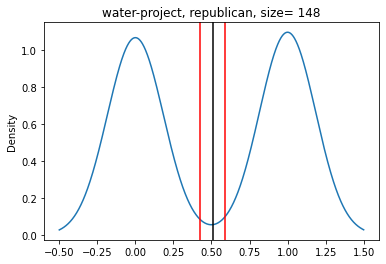

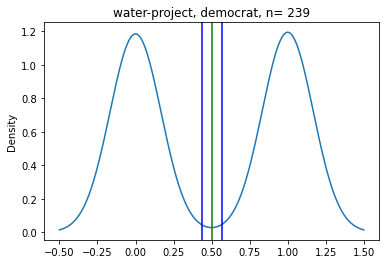

In [39]:
import matplotlib.pyplot as plt

wj_rep.plot.density()
plt.axvline(x=lower_r, color='red')
plt.axvline(x=mean_r, color='black')
plt.axvline(x=upper_r, color='red')
plt.title('water-project, republican, size= 148')
plt.show()


# Republican on water-project data 
# total length is 148, vote for yes is 75
# vote no : 73
# vote yes: 75
# two peak quite equal from  density distribution

# Democrat on water-project data 
# total length is 239, vote for yes is 120
# vote no : 119
# vote yes: 120
# two peak quite equal from  density distribution

wj_dem.plot.density()
plt.axvline(x=lower_d, color='blue')
plt.axvline(x=mean_d, color='green')
plt.axvline(x=upper_d, color='blue')
plt.title('water-project, democrat, n= 239')
plt.show()


In [0]:
# Conclusion:
# 1. based on above 2 graph, the confidence interval of democrat is narrower, that means, sample size is bigger
# and both mean value is quite closely located to the center (0.5) 
# 2. density distribution, dem has more sample size, two peaks for 1 and zero are higher than republican
# 3. on water-project issue, we can say we have 95% of confidence to say both parties is noticablly well represented the American 
#    population of their voters.
# 4, democrat has higher p value than republican, and both all fail to reject the null Hypothesis, the two samples depicted that they are truely represented their voters
#    (American population)

# Republican on water-project data 
# total length is 148, vote for yes is 75
# vote no : 73
# vote yes: 75
# two peak quite equal from  density distribution

# Democrat on water-project data 
# total length is 239, vote for yes is 120
# vote no : 119
# vote yes: 120
# two peak quite equal from  density distribution



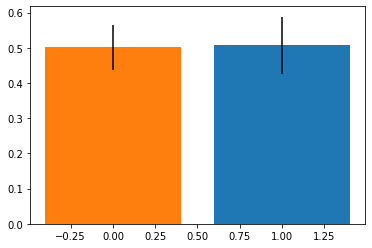

In [42]:
plt.bar(1, mean_r, yerr=moe_r)
plt.bar(0, mean_d, yerr=moe_d)
plt.show()

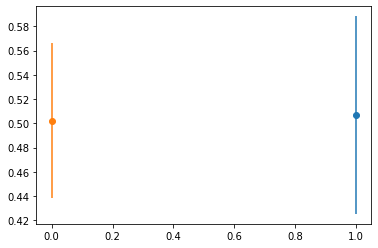

In [40]:
import matplotlib.pyplot as plt

plt.errorbar(1, mean_r, yerr=moe_r, fmt='o')
plt.errorbar(0, mean_d, yerr=moe_d, fmt='o')
plt.show()

In [0]:
#######################################
#
#          Run a  𝜒2  Test "by hand" (Using Numpy)
#
#######################################

In [81]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=" ?")
print(df.shape)
df.info()

(32561, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  country         31978 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [0]:
df.describe()

In [0]:
df.describe(exclude='number')

In [84]:

observed = pd.crosstab(df['sex'], df['education-num'])
observed_margins = pd.crosstab(df['sex'], df['education-num'], margins=True)
observed_margins


education-num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,All
sex,,,,,,,,,,,,,,,,,
Female,16,46,84,160,144,295,432,144,3390,2806,500,421,1619,536,92,86,10771
Male,35,122,249,486,370,638,743,289,7111,4485,882,646,3736,1187,484,327,21790
All,51,168,333,646,514,933,1175,433,10501,7291,1382,1067,5355,1723,576,413,32561


In [85]:
total_total = df.shape[0]
total_total

32561

In [86]:
# grab the row sums from the crosstab
row_sums = observed_margins.iloc[0:2, 16:].values
row_sums = row_sums.T[0]

row_sums

array([10771, 21790])

In [87]:
# grab the column sums from the crosstab
col_sums = observed_margins.iloc[2:, 0:16].values
col_sums = col_sums[0]

col_sums

array([   51,   168,   333,   646,   514,   933,  1175,   433, 10501,
        7291,  1382,  1067,  5355,  1723,   576,   413])

In [88]:
# to get the expected value

expected = []
for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column*row_sums[i]/total_total
    expected_row.append(expected_val)
  expected.append(expected_row)

expected = np.array(expected)
print(expected.shape)  
print(expected)

(2, 16)
[[  16.87051995   55.57347747  110.15457142  213.69325266  170.02837751
   308.63127668  388.6835478   143.2340223  3473.67313657 2411.82276343
   457.15801112  352.95774086 1771.40459445  569.95893861  190.53763705
   136.61813212]
 [  34.12948005  112.42652253  222.84542858  432.30674734  343.97162249
   624.36872332  786.3164522   289.7659777  7027.32686343 4879.17723657
   924.84198888  714.04225914 3583.59540555 1153.04106139  385.46236295
   276.38186788]]


In [89]:
chi2 = ((observed - expected)**2 / expected).sum().sum()

chi2



297.7150037250369

In [91]:
dof = (2-1)*(16-1)
from scipy import stats

# pass in our observed value table (contingency table)
chi2, p_value, dof, expected = stats.chi2_contingency(observed)

print(" chi2 statistic", chi2)
print("\n p-value", p_value)
print("\n degrees of freedom",dof)
print("\n expected frequencies table: \n", expected)

 chi2 statistic 297.7150037250368

 p-value 1.6677784409205546e-54

 degrees of freedom 15

 expected frequencies table: 
 [[  16.87051995   55.57347747  110.15457142  213.69325266  170.02837751
   308.63127668  388.6835478   143.2340223  3473.67313657 2411.82276343
   457.15801112  352.95774086 1771.40459445  569.95893861  190.53763705
   136.61813212]
 [  34.12948005  112.42652253  222.84542858  432.30674734  343.97162249
   624.36872332  786.3164522   289.7659777  7027.32686343 4879.17723657
   924.84198888  714.04225914 3583.59540555 1153.04106139  385.46236295
   276.38186788]]


In [0]:
# At chi2 value is 297.71, dof = 15, - check the table, we got p=0,
That means, we reject null Hypothesis, that gender and years of education is independent, they are closely related.


## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)